Mounted at /content/drive
Execution Time: 0.0368 seconds
Number of Columns: 11
Price Increases: 1460
Price Decreases: 1141
Sample Increase Rows:
                 Country       Date     Open     Close        Volume  \
0  China, Hong Kong SAR 2016-02-21  906.700  910.2075  1.096639e+10   
2  China, Hong Kong SAR 2016-03-06  926.802  929.9140  1.463376e+10   

            GDP     GNI (USD)  Population  Exchange Rate (AMA)  Price Change  \
0  3.210000e+11  3.290000e+11   7435927.0              7.76225        3.5075   
2  3.210000e+11  3.290000e+11   7435927.0              7.76225        3.1120   

        Week  
0 2016-02-15  
2 2016-02-29  
Sample Decrease Rows:
                  Country       Date     Open    Close        Volume  \
1   China, Hong Kong SAR 2016-02-28  922.902  922.740  1.153907e+10   
10  China, Hong Kong SAR 2016-05-01  979.860  979.576  1.180989e+10   

             GDP     GNI (USD)  Population  Exchange Rate (AMA)  Price Change  \
1   3.210000e+11  3.290000e+11   743

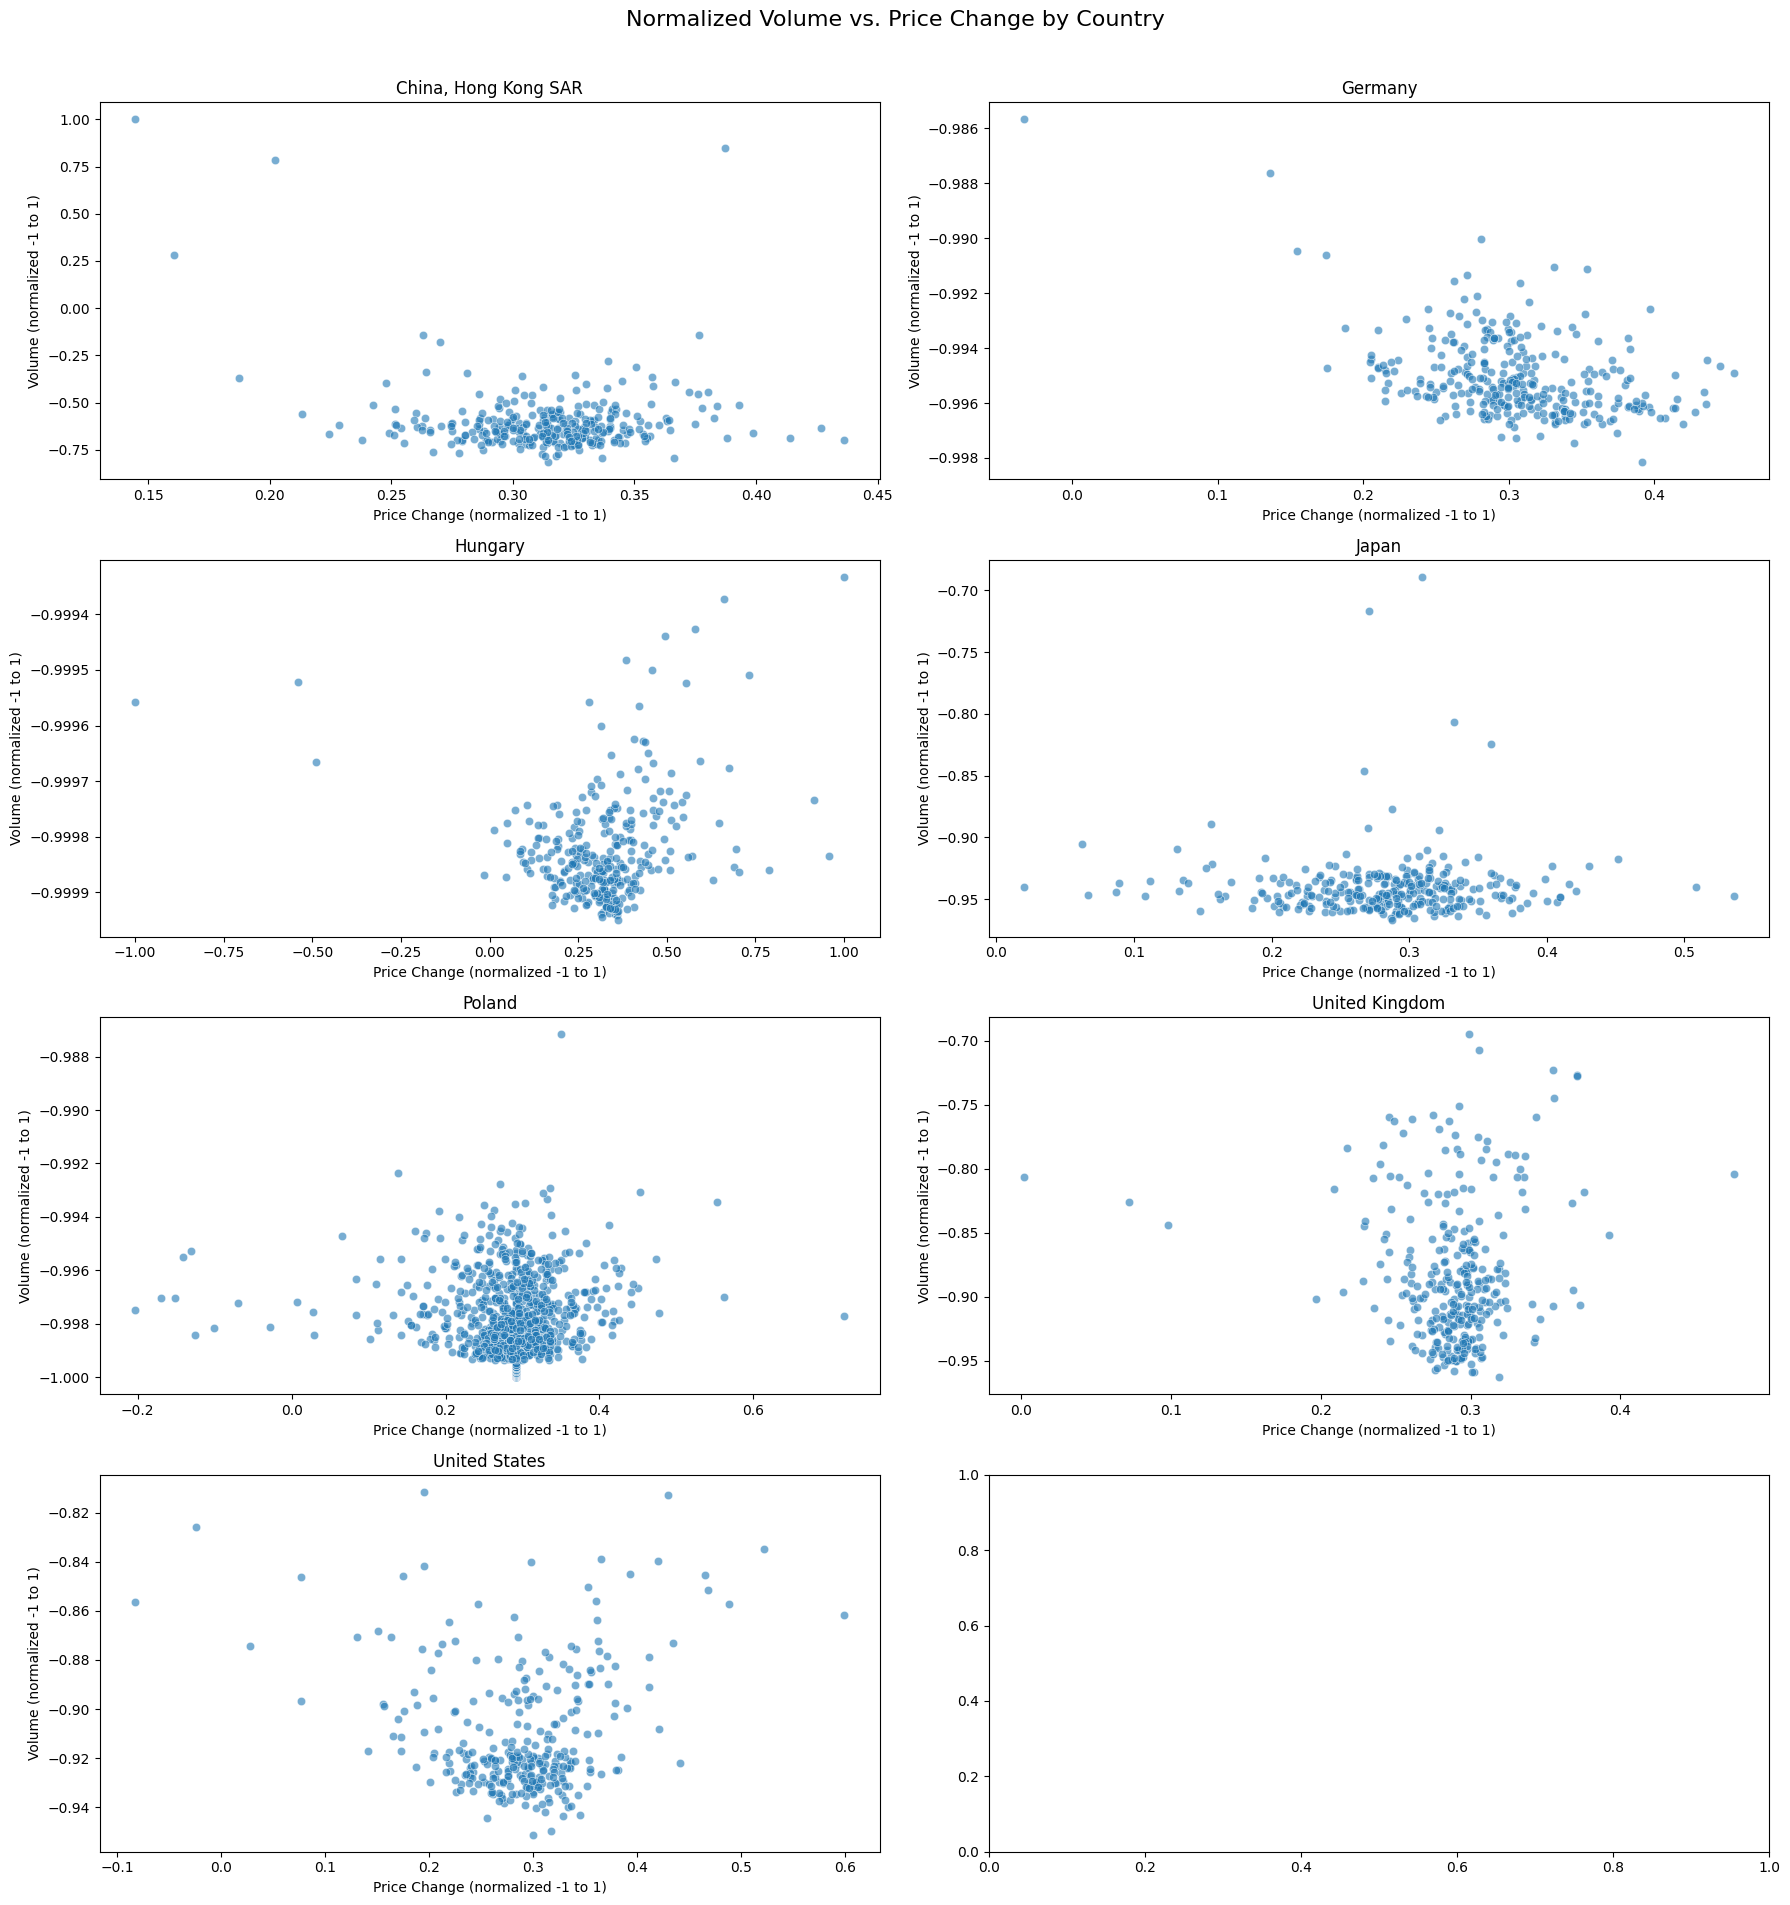

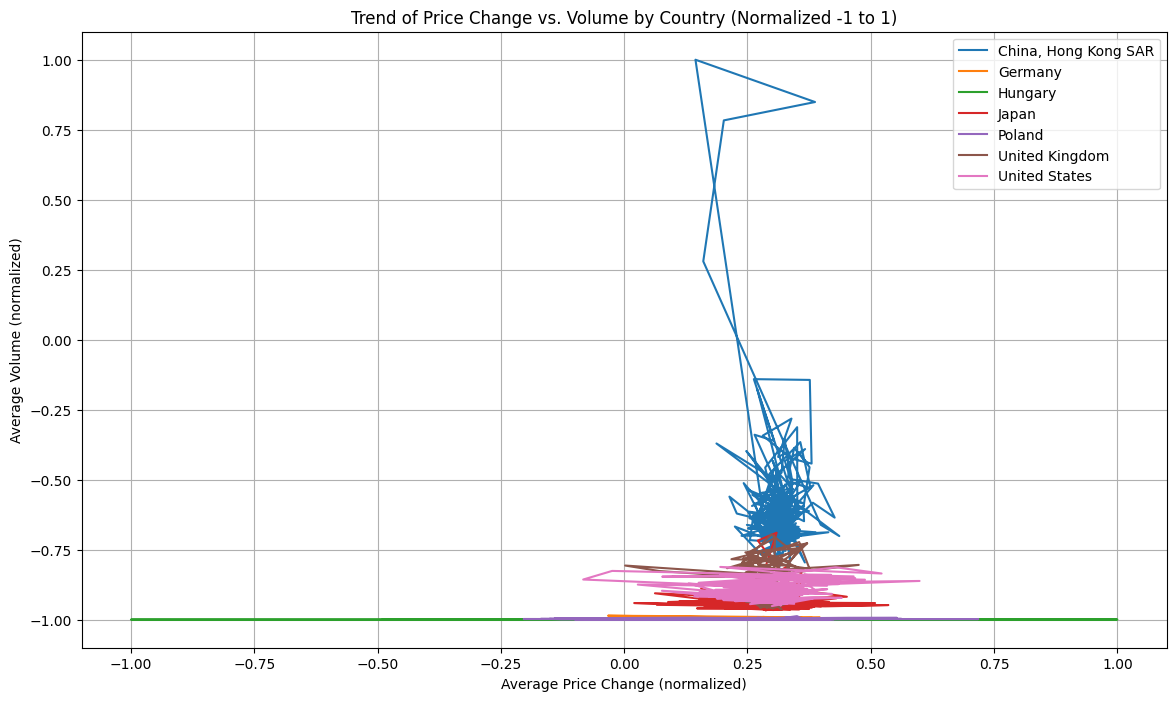


Pearson Correlation between Price Change and Volume by Country:
China, Hong Kong SAR: -0.2192
Germany: -0.4348
Hungary: 0.1261
Japan: 0.0108
Poland: -0.0452
United Kingdom: 0.0073
United States: 0.0240


In [5]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# --- Imports and Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import time

start_time = time.time()

# --- Load Dataset ---
# Load the CSV data into a DataFrame. Make sure the file path is valid in your Colab environment.
file_path = "/content/drive/MyDrive/CSC442 Team Project/Output/final5b_weekly.csv"
df = pd.read_csv(file_path)

# --- Data Preparation ---
# Clean column names to make them easier to work with
df.rename(columns={"<OPEN>": "Open", "<CLOSE>": "Close", "<VOL>": "Volume"}, inplace=True)

# Convert 'Date' to datetime format so we can group and analyze over time
df["Date"] = pd.to_datetime(df["Date"])

# Calculate raw price change (not percentage), keeping direction of movement
df["Price Change"] = df["Close"] - df["Open"]

# Create a 'Week' column to enable grouping for weekly averages
df["Week"] = df["Date"].dt.to_period("W").dt.start_time

# --- Querying Price Movement Data ---
# Track how many rows increased or decreased in price and print two sample rows from each group
increase_rows = df[df["Price Change"] > 0]
decrease_rows = df[df["Price Change"] < 0]
increase_count = len(increase_rows)
decrease_count = len(decrease_rows)
sample_increase = increase_rows.head(2)
sample_decrease = decrease_rows.head(2)

query_duration = time.time() - start_time

# Display summary of query
print(f"Execution Time: {query_duration:.4f} seconds")
print(f"Number of Columns: {df.shape[1]}")
print(f"Price Increases: {increase_count}")
print(f"Price Decreases: {decrease_count}")
print("Sample Increase Rows:\n", sample_increase)
print("Sample Decrease Rows:\n", sample_decrease)

# --- Normalization ---
# Normalize Open, Close, Volume, and Price Change using a scale of -1 to 1
# This preserves the direction (positive vs. negative) of price changes while standardizing values
scaler = MinMaxScaler(feature_range=(-1, 1))
df[["Open", "Close", "Volume", "Price Change"]] = scaler.fit_transform(
    df[["Open", "Close", "Volume", "Price Change"]]
)

# --- Scatter Plots by Country ---
# Create a scatter plot for each country to explore relationship between price change and volume
unique_countries = df["Country"].unique()
fig, axes = plt.subplots(4, 2, figsize=(18, 20))
fig.suptitle("Normalized Volume vs. Price Change by Country", fontsize=16)

# One plot per country
for ax, country in zip(axes.flatten(), unique_countries):
    country_df = df[df["Country"] == country]
    sns.scatterplot(data=country_df, x="Price Change", y="Volume", ax=ax, alpha=0.6)
    ax.set_title(country)
    ax.set_xlabel("Price Change (normalized -1 to 1)")
    ax.set_ylabel("Volume (normalized -1 to 1)")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

# --- Multi-Country Line Graph ---
# Plot the relationship over time between average price change and volume by country
plt.figure(figsize=(14, 8))
for country in unique_countries:
    subset = df[df["Country"] == country]
    avg_weekly = subset.groupby("Week")[["Price Change", "Volume"]].mean().sort_index()
    plt.plot(avg_weekly["Price Change"], avg_weekly["Volume"], label=country)

plt.title("Trend of Price Change vs. Volume by Country (Normalized -1 to 1)")
plt.xlabel("Average Price Change (normalized)")
plt.ylabel("Average Volume (normalized)")
plt.legend()
plt.grid(True)
plt.show()

# --- Correlation Calculation ---
# Quantify the relationship between price change and volume using Pearson correlation
print("\nPearson Correlation between Price Change and Volume by Country:")
for country in unique_countries:
    subset = df[df["Country"] == country]
    corr = subset["Price Change"].corr(subset["Volume"])
    print(f"{country}: {corr:.4f}")